# Regression with an Abalone Dataset

## 🔗 Kaggle Veri Seti
[Abalone Dataset](https://www.kaggle.com/datasets/rodolfomendes/abalone-dataset)

##### [Abalone Dataset - Hugging Face](https://huggingface.co/spaces/btulftma/abalone_dataset)

##### Detaylı açıklama ve kodlar için 
[Abalone Dataset - Github](https://github.com/FBetulS/Abalone-Dataset)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [5]:
train.describe()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,45307.000000,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,26158.441658,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22653.500000,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.500000,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,90614.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [6]:
train.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64

In [7]:
# 'Sex' sütununu sayısala dönüştür
train['Sex'] = train['Sex'].map({'M': 0, 'F': 1, 'I': 2})
test['Sex'] = test['Sex'].map({'M': 0, 'F': 1, 'I': 2})

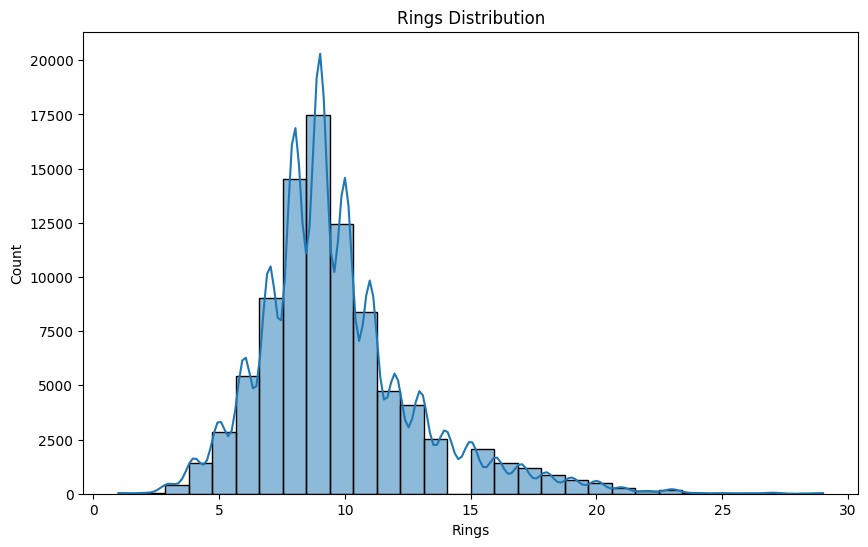

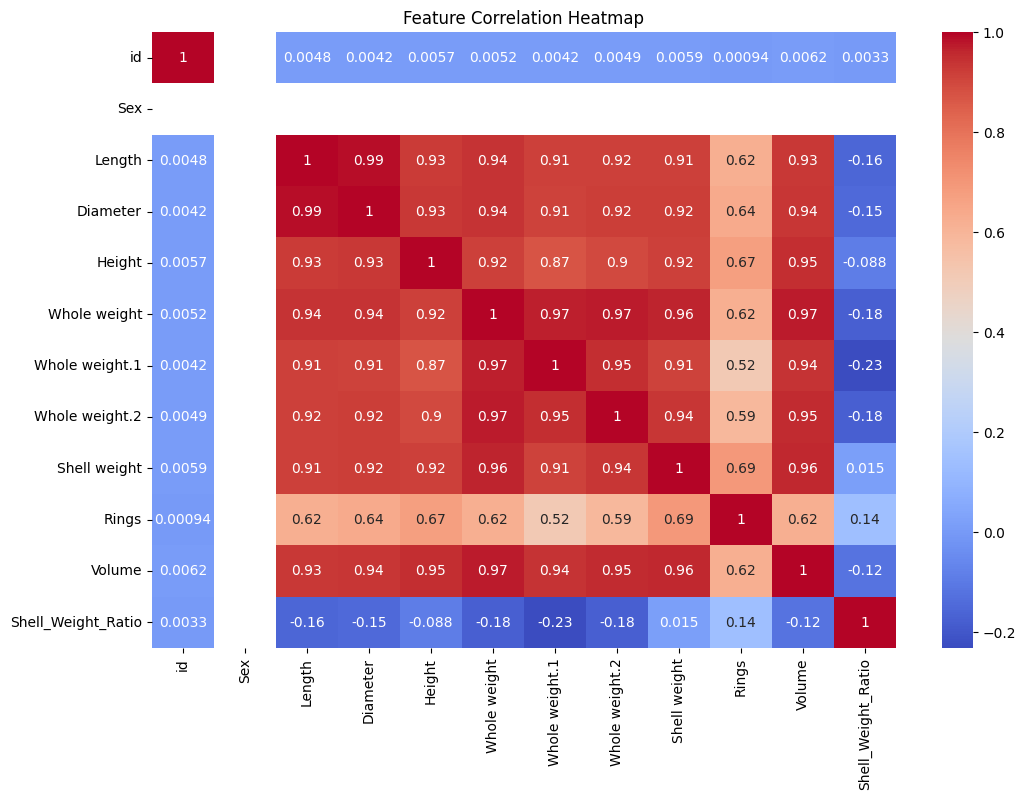

In [8]:
# 'Sex' sütununu sayısala dönüştür
train['Sex'] = train['Sex'].map({'M': 0, 'F': 1, 'I': 2})
test['Sex'] = test['Sex'].map({'M': 0, 'F': 1, 'I': 2})
# Hacim hesapla
train['Volume'] = train['Length'] * train['Diameter'] * train['Height']
test['Volume'] = test['Length'] * test['Diameter'] * test['Height']

# Ağırlık oranları
train['Shell_Weight_Ratio'] = train['Shell weight'] / train['Whole weight']
test['Shell_Weight_Ratio'] = test['Shell weight'] / test['Whole weight']
# Outlier'ları kırpma fonksiyonu
def clip_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower_bound, upper_bound)

# Outlier temizleme
for col in ['Length', 'Diameter', 'Height', 'Whole weight']:
    clip_outliers(train, col)
    clip_outliers(test, col)
# 'Rings' dağılımı
plt.figure(figsize=(10, 6))
sns.histplot(train['Rings'], bins=30, kde=True)
plt.title('Rings Distribution')
plt.show()
# Korelasyon matrisi
corr = train.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [9]:
# Hacim hesapla
train['Volume'] = train['Length'] * train['Diameter'] * train['Height']
test['Volume'] = test['Length'] * test['Diameter'] * test['Height']

# Ağırlık oranları
train['Shell_Weight_Ratio'] = train['Shell weight'] / train['Whole weight']
test['Shell_Weight_Ratio'] = test['Shell weight'] / test['Whole weight']

In [10]:
# Outlier'ları kırpma fonksiyonu
def clip_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower_bound, upper_bound)

# Outlier temizleme
for col in ['Length', 'Diameter', 'Height', 'Whole weight']:
    clip_outliers(train, col)
    clip_outliers(test, col)

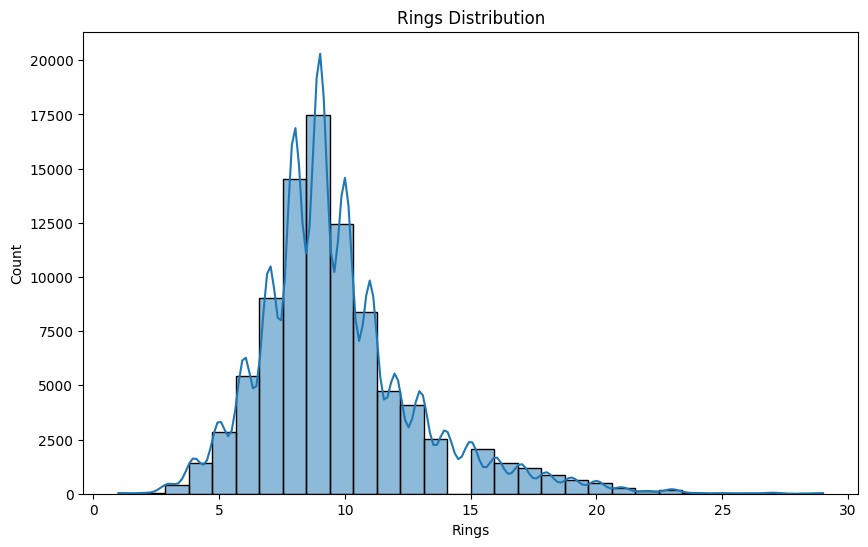

In [11]:
# 'Rings' dağılımı
plt.figure(figsize=(10, 6))
sns.histplot(train['Rings'], bins=30, kde=True)
plt.title('Rings Distribution')
plt.show()

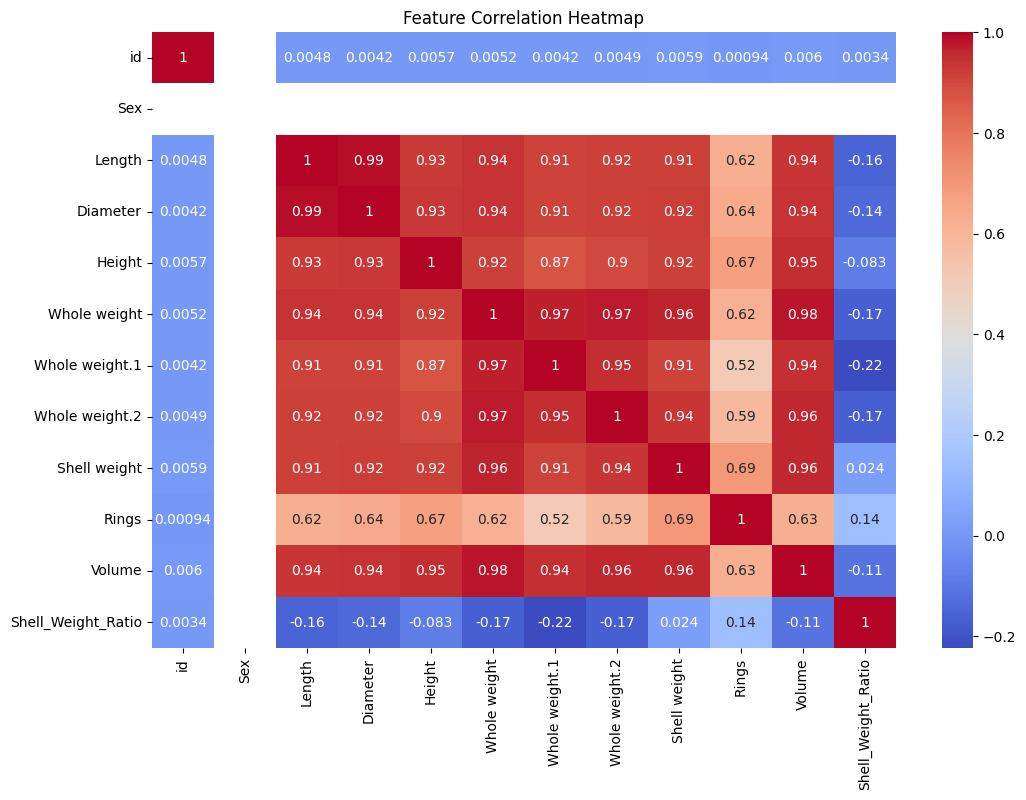

In [12]:
# Korelasyon matrisi
corr = train.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [13]:
X = train.drop(['id', 'Rings'], axis=1)
y = train['Rings']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# XGBoost modeli
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

xgb_preds = xgb_model.predict(X_val)

xgb_rmse = mean_squared_error(y_val, xgb_preds, squared=False)
print("XGBoost RMSE:", xgb_rmse)

XGBoost RMSE: 1.8933354915429204


C:\Users\BETÜL\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [15]:
# Random Forest modeli
rf_model = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_val)

rf_rmse = mean_squared_error(y_val, rf_preds, squared=False)
print("Random Forest RMSE:", rf_rmse)

Random Forest RMSE: 1.9025495768261786


C:\Users\BETÜL\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


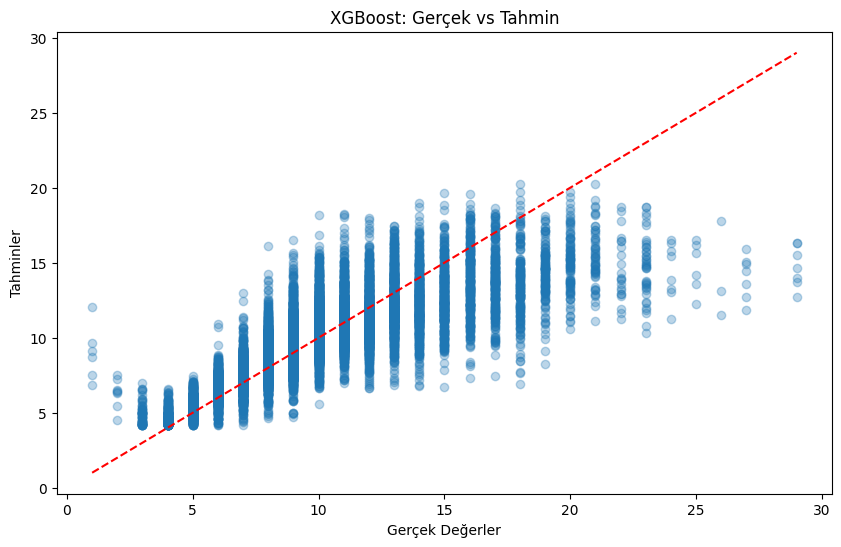

In [16]:
# XGBoost için gerçek vs tahmin
plt.figure(figsize=(10, 6))
plt.scatter(y_val, xgb_preds, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahminler')
plt.title('XGBoost: Gerçek vs Tahmin')
plt.show()

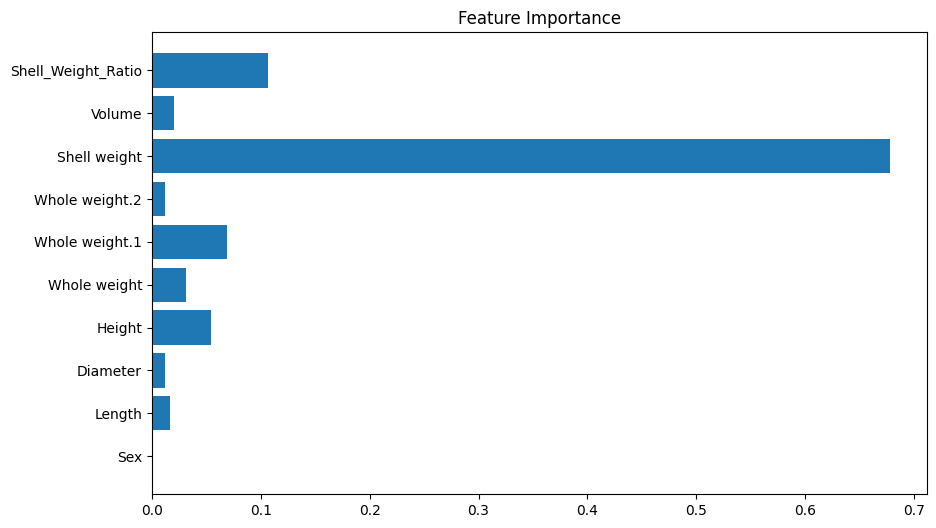

In [17]:
# XGBoost feature importance
importances = xgb_model.feature_importances_
feature_names = X_train.columns
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.title('Feature Importance')
plt.show()

In [18]:
test_preds = xgb_model.predict(test.drop('id', axis=1))

submission = pd.DataFrame({'id': test['id'], 'Rings': test_preds})
submission.to_csv('abalone_submission.csv', index=False)

In [34]:
import joblib
joblib.dump(xgb_model, 'xgb_abalone_model.pkl')
joblib.dump(rf_model, 'rf_abalone_model.pkl')

['rf_abalone_model.pkl']

In [40]:
xgb_model = XGBRegressor(n_estimators=1000, 
                        learning_rate=0.01, 
                        max_depth=5, 
                        random_state=42)

xgb_model.fit(X_train, y_train)

xgb_model.save_model('xgb_model.json')
joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']

In [42]:
features = ['Sex', 'Length', 'Diameter', 'Height', 
           'Whole weight', 'Whole weight.1', 
           'Whole weight.2', 'Shell weight']

X = train[features]
y = train['Rings']

xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=42)
xgb_model.fit(X, y)

xgb_model.save_model('xgb_model.json')
joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']

In [44]:
features = ['Sex', 'Length', 'Diameter', 'Height', 
            'Whole weight', 'Whole weight.1', 
            'Whole weight.2', 'Shell weight']

X = train[features]
y = train['Rings']

xgb_model = XGBRegressor(n_estimators=1000, 
                        learning_rate=0.01, 
                        max_depth=5, 
                        random_state=42)
xgb_model.fit(X, y)

xgb_model.save_model('xgb_model.json')
joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']

In [46]:
train = pd.read_csv('train.csv')  
features = ['Sex', 'Length', 'Diameter', 'Height', 
           'Whole weight', 'Whole weight.1', 
           'Whole weight.2', 'Shell weight']

X = train[features]
y = train['Rings']
X['Sex'] = X['Sex'].map({'F': 0, 'I': 1, 'M': 2})

xgb_model = XGBRegressor(n_estimators=1000, 
                        learning_rate=0.01, 
                        max_depth=5, 
                        random_state=42)
xgb_model.fit(X, y)

xgb_model.save_model('xgb_model.json')
joblib.dump(xgb_model, 'xgb_model.pkl')

print("Model başarıyla eğitildi ve kaydedildi!")

C:\Users\BETÜL\AppData\Local\Temp\ipykernel_17996\2389261758.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sex'] = X['Sex'].map({'F': 0, 'I': 1, 'M': 2})


Model başarıyla eğitildi ve kaydedildi!
